# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


## Question 5f

In this open solution, we detail the our approach where we explore if the inclusion
of self attention in the RNN baseline model can serve to improve the model to 
perform well for this dataset.


### Approach

We will use the original RNN model defined in Part 2 and add a self attention layer
to the model. The self attention layer will be added after the RNN layer and before the
final dense layer. The self attention layer will help the model to focus on the most
important words in the sentence and hence improve the performance of the model.

This is in contrast to just applying a simple max pooling where we only simply obtain
the max value of the hidden states of the RNN layer.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from common_utils import EmbeddingMatrix
from common_utils import train_model, plot_loss_accuracy, test_loop, set_seed
from common_utils import HIDDEN_SIZE, EMBEDDING_DIM, LEARNING_RATE
# set seed 
set_seed()

In [2]:
from common_utils import CustomDatasetPreparer, BATCH_SIZE


dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders(shuffle=False)

In [3]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x,_,lenghts, sample_y = next(dataiter)

# print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)
print()
print('Sample label size: ', lenghts.size()) # batch_size
print('Sample label: \n', lenghts)

Sample input: 
 tensor([[ 9763, 16163, 16163, 16163],
        [ 6878, 16163, 16163, 16163],
        [13359, 12014, 16163, 16163],
        [ 3703, 11700, 16163, 16163],
        [13968,  7417, 16163, 16163],
        [14620,     0, 16163, 16163],
        [11567,    30, 16163, 16163],
        [ 5252,     0, 16163, 16163],
        [ 5011,    30, 16163, 16163],
        [12687,    30, 16163, 16163],
        [ 4544,    30, 16163, 16163],
        [  289, 10258, 16163, 16163],
        [14404,  4741,    30, 16163],
        [ 5229,  5262,    30, 16163],
        [ 2872, 15646,    30, 16163],
        [ 9822,  6733,    30, 16163],
        [11118, 12282,    30, 16163],
        [ 9865, 16164,    30, 16163],
        [ 6729,  4722,    30, 16163],
        [ 1366, 10988,    30, 16163],
        [11118, 11860,    30, 16163],
        [15513,  2175,    30, 16163],
        [ 9255, 12014,    30, 16163],
        [ 6016, 15174,    30, 16163],
        [ 3699, 13070,    30, 16163],
        [ 5006,  4177,    30, 1616

# Part 3 - Open topic

## RNN with attention

We first explore if the use of attention in RNN can improve the performance of the model. Our
basis is that the attention mechanism can help the model to focus on the most relevant words in the
input sequence.

In [4]:
class RNNWithAttention(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )  # this is the num rows of the input matrix
        self.attention = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        
        if self.dropout_rate > 0:
            embedded = self.dropout(self.embedding(x)).float()
        else:
            embedded = self.embedding(x).float()

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted = False)
        packed_output, _ = self.rnn(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        if self.dropout_rate > 0:
            output = self.dropout(output)
        
        # Calculate attention scores
        attention_weights = torch.softmax(self.attention(output), dim=1)
        # Apply attention weights to RNN outputs
        context_vector = torch.sum(attention_weights * output, dim=1)
        out = self.fc(context_vector)
        sig_out = self.sigmoid(out)
        # sig_out = sig_out.squeeze(1)
        return sig_out

from common_utils import HIDDEN_SIZE, EMBEDDING_DIM, LEARNING_RATE
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


rnn_attention = RNNWithAttention(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.3,
    pad_idx=word_embeddings.pad_idx,
    num_layers=2,
)

The index of <PAD> is:  16163


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = rnn_attention
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

In [6]:
train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

  1%|          | 1/100 [00:01<03:06,  1.88s/it]

epoch 1, train_loss 0.654882 train_acc 0.610317, val_loss 0.567608, val_acc 0.710131


 11%|█         | 11/100 [00:19<02:39,  1.79s/it]

epoch 11, train_loss 0.297293 train_acc 0.877022, val_loss 0.470429, val_acc 0.785178


 19%|█▉        | 19/100 [00:36<02:34,  1.91s/it]

early stopping after 20 epochs
best val loss: 0.4694844714619897
best accuracy on val set: 0.7870544090056285


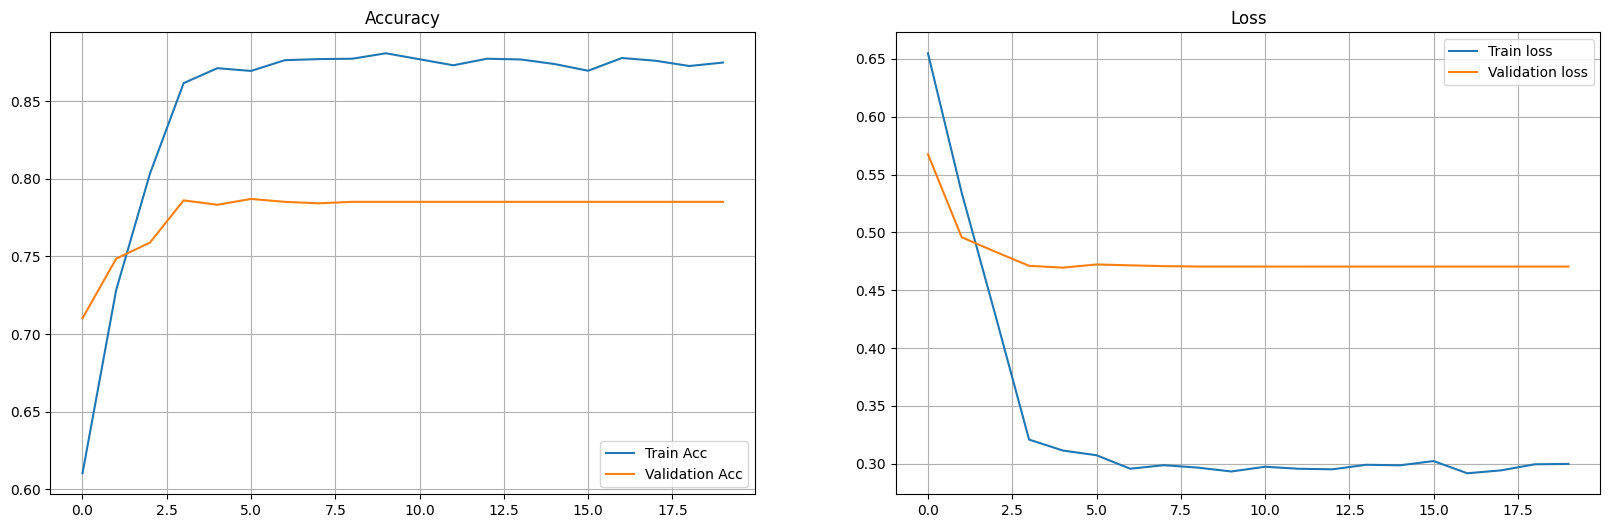

test_loss 0.419041, test_acc 0.814259


In [7]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## RNN with Max and Average Pooling

Now we will test the model with Max pooling and Average pooling and concatenate the results with the output of the RNN layer. In
Part 2, we explore the use of either, but now we try to concatenate the results of both pooling methods. We aim to see if the model can make use of both pooling methods to improve the performance of the model.

In [8]:
class RNN_MaxAvePooling(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )  # this is the num rows of the input matrix
        
        # note that because we are using a concatenate of max and average pooling, the output size of the linear layer should be 2*hidden_dim
        self.fc = nn.Linear(2*hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        if self.dropout_rate > 0:
            embedded = self.dropout(self.embedding(x)).float()
        else:
            embedded = self.embedding(x).float()

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted = False)
        packed_output, _ = self.rnn(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        if self.dropout_rate > 0:
            output = self.dropout(output)
        
        # max pooling
        output1, _ = torch.max(output, 1)
        # average pooling
        output2 = torch.mean(output, 1)
        # concatenate max and average pooling
        output = torch.cat((output1, output2), 1)

        out = self.fc(output)  # Use the last output of the RNN for classification

        sig_out = self.sigmoid(out)
        sig_out = sig_out.squeeze(1)
        # print("Sig_out shape: ", sig_out.shape)
        return sig_out

In [9]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


rnn_with_maxave_pool = RNN_MaxAvePooling(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.6,
    pad_idx=word_embeddings.pad_idx,
    num_layers=2,
)

The index of <PAD> is:  16163


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = rnn_with_maxave_pool
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model = model.to(device)
loss_fn = loss_fn.to(device)

In [11]:
train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

  1%|          | 1/100 [00:01<03:13,  1.95s/it]

epoch 1, train_loss 0.883981 train_acc 0.453576, val_loss 0.709481, val_acc 0.437148


 11%|█         | 11/100 [00:20<02:39,  1.79s/it]

epoch 11, train_loss 0.383177 train_acc 0.828722, val_loss 0.538731, val_acc 0.739212


 21%|██        | 21/100 [00:37<02:21,  1.79s/it]

epoch 21, train_loss 0.377314 train_acc 0.835404, val_loss 0.538473, val_acc 0.739212


 31%|███       | 31/100 [00:55<01:58,  1.72s/it]

epoch 31, train_loss 0.384244 train_acc 0.825909, val_loss 0.538473, val_acc 0.739212


 34%|███▍      | 34/100 [01:02<02:00,  1.83s/it]

early stopping after 35 epochs
best val loss: 0.5384728339585391
best accuracy on val set: 0.7429643527204502


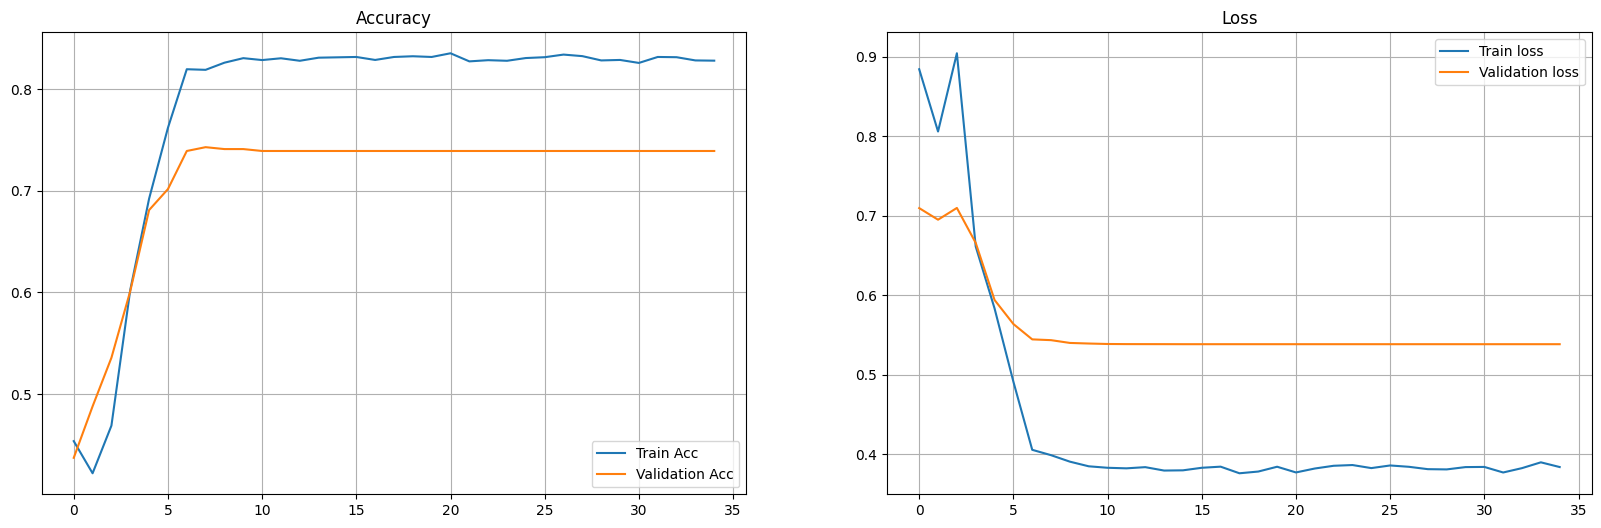

test_loss 0.496266, test_acc 0.770169


In [12]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## Self Attention

We now explore what was taught in lectures, which is self attention where the model
tries to learn how to apply attention to the input sequence. We will add a self attention layer
and a Residual connection to the model. We aim to see if the model can learn to focus on the most
important words in the input sequence and hence improve the performance of the model.

In [13]:
import torch

class SelfAttention(nn.Module):
    """
    Multi-head self attention layer
    """
    def __init__(self, embed_dim, heads=5, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        assert (
            self.head_dim * heads == embed_dim
        ), "Embedding dimension must be divisible by number of heads"

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape  # Batch size, sequence length, embedding dimension
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calculate attention scores
        attn = (q @ k.transpose(-2, -1)) * self.head_dim**-0.5
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return out
class SelfAttentionResNet(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        heads=5,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.heads = heads
        
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout_rate)

        self.self_attention_layers = nn.ModuleList([
            SelfAttention(embedding_dim, heads, dropout_rate) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, output_size)

        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        
        out = embedded
        for layer in self.self_attention_layers:
            out = layer(out) + out  # Residual connection

        out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        
        sig_out = self.sigmoid(out)
        sig_out = sig_out.squeeze(1)
        return sig_out

In [18]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


self_atten_resnet = SelfAttentionResNet(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.3,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)

The index of <PAD> is:  16163


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = self_atten_resnet
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model = model.to(device)
loss_fn = loss_fn.to(device)

In [20]:
train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

  1%|          | 1/100 [00:01<02:30,  1.52s/it]

epoch 1, train_loss 0.563742 train_acc 0.716647, val_loss 0.499479, val_acc 0.774859


 11%|█         | 11/100 [00:16<02:08,  1.45s/it]

epoch 11, train_loss 0.005095 train_acc 0.998476, val_loss 2.122544, val_acc 0.760788


 15%|█▌        | 15/100 [00:22<02:09,  1.53s/it]

early stopping after 16 epochs
best val loss: 0.4994788007302718
best accuracy on val set: 0.774859287054409


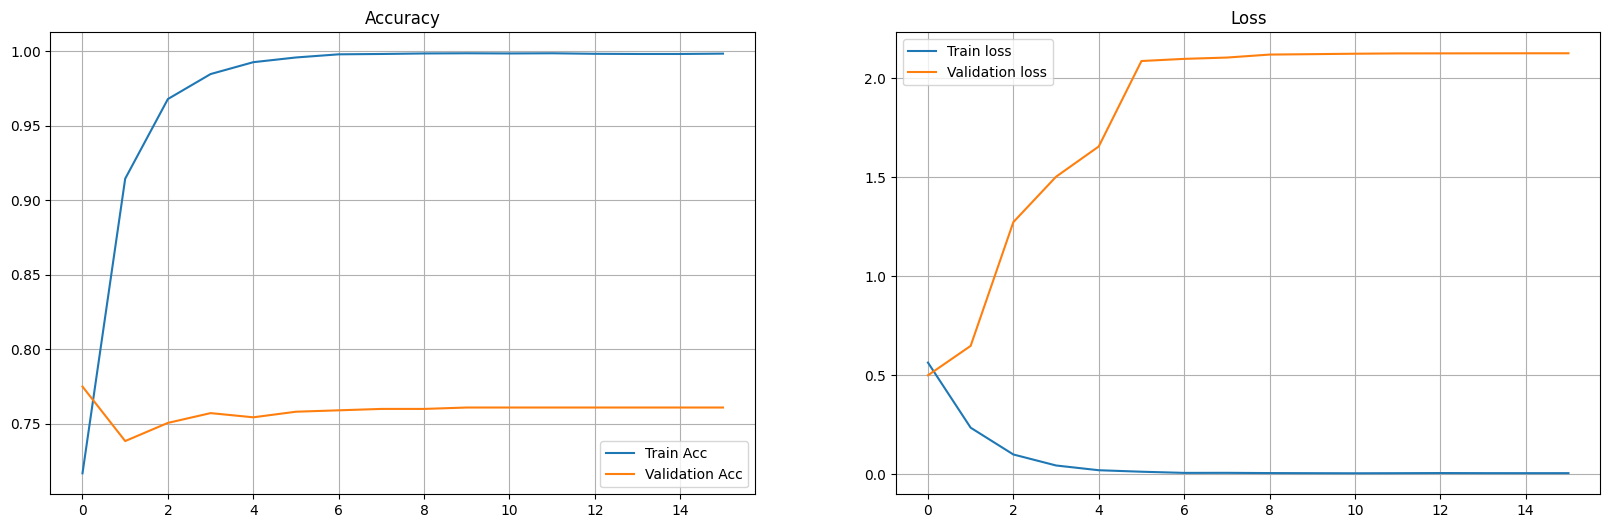

test_loss 1.998872, test_acc 0.754221


In [21]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## Self Attention with layers

In [ ]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


self_atten_resnet = SelfAttentionResNet(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.5,
    pad_idx=word_embeddings.pad_idx,
    num_layers=2,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = self_atten_resnet
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.05)

model = model.to(device)
loss_fn = loss_fn.to(device)

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

In [ ]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## Self Attention with Positional Encoding

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class SelfAttentionResNetPositionalEncoding(nn.Module):

    def __init__(
        self,
        hidden_dim: int,
        embedding_dim: int,
        word_embeddings: torch.Tensor,
        pad_idx,
        heads=5,
        num_layers=1,
        output_size=1,
        dropout_rate=0
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.heads = heads
        
        self.embedding = nn.Embedding.from_pretrained(word_embeddings, freeze=False, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout_rate)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout_rate)
        # self.self_attention = SelfAttention(embedding_dim, heads)
        
        self.self_attention_layers = nn.ModuleList([
            SelfAttention(embedding_dim, heads, dropout_rate) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, output_size)

        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x, text_lengths):
        embedded = self.embedding(x)
        embedded = self.pos_encoder(embedded)
        
        out = embedded
        for layer in self.self_attention_layers:
            out = layer(out) + out  # Residual connection
            
        out = torch.mean(out, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        
        sig_out = self.sigmoid(out)
        sig_out = sig_out.squeeze(1)
        # print("Sig_out shape: ", sig_out.shape)
        return sig_out

In [25]:
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.add_unk_token()

print("The index of <PAD> is: ", word_embeddings.pad_idx)


self_atten_resnet = SelfAttentionResNetPositionalEncoding(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.5,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = self_atten_resnet
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model = model.to(device)
loss_fn = loss_fn.to(device)

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

The index of <PAD> is:  16163


  1%|          | 1/100 [00:01<02:39,  1.61s/it]

epoch 1, train_loss 0.733080 train_acc 0.510317, val_loss 0.615464, val_acc 0.674484


 11%|█         | 11/100 [00:18<02:21,  1.59s/it]

epoch 11, train_loss 0.303496 train_acc 0.878312, val_loss 0.627263, val_acc 0.739212


 16%|█▌        | 16/100 [00:28<02:27,  1.76s/it]

early stopping after 17 epochs
best val loss: 0.5671080364422365
best accuracy on val set: 0.7448405253283302


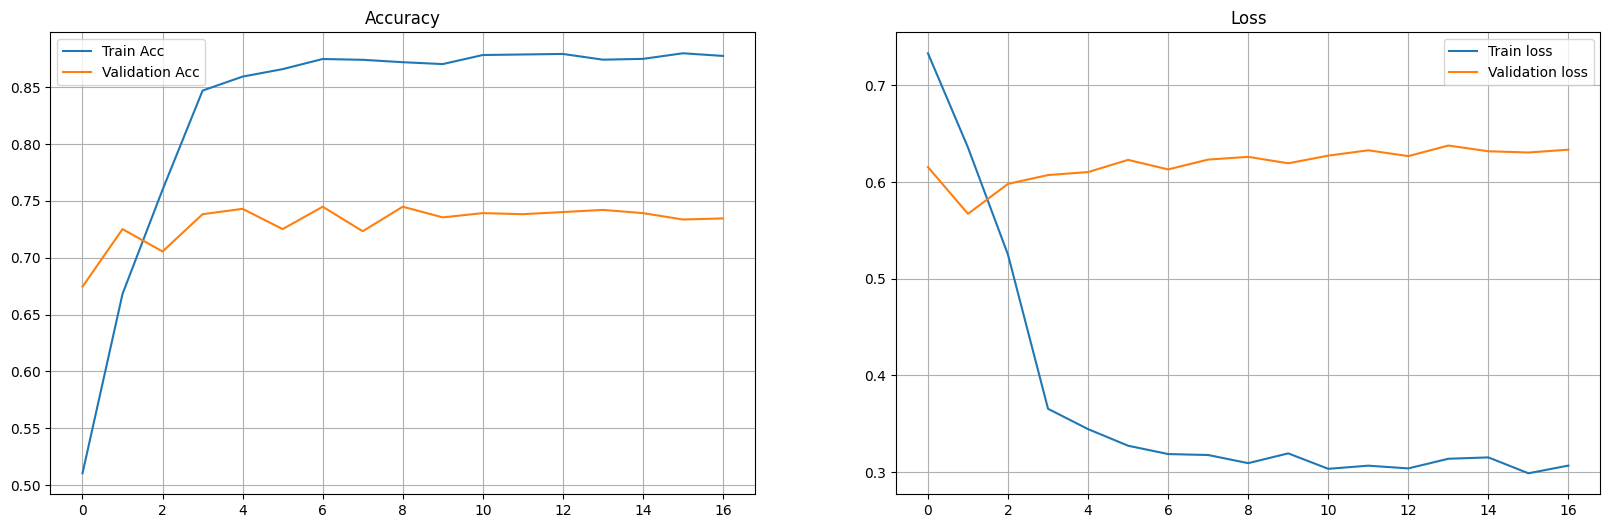

test_loss 0.580599, test_acc 0.742026


In [26]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

## Negation handling

While creating new models are techniques are important, we also explore if the model can be improved by handling negation in the input sequence. We will data augment the dataset by adding negation to the input.

Here is how we will do it

In [2]:
from nltk.corpus import wordnet
# ref: https://github.com/UtkarshRedd/Negation_handling/blob/main/NegationHandling.py
def negation_handler(sentence):	
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't", 'no', 'never', 'but','nevertheless', 'if']:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wordnet.synsets(ant)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp>max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        sentence[i] = antonym_max
                        sentence[i-1] = ''
    while '' in sentence:
        sentence = list(filter(lambda a: a != '', sentence))
    return sentence

In [3]:
from datasets import load_dataset, Dataset
import nltk

dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']

print("Original dataset shape: ", train_dataset.shape)

negated_tokenised_sentence = []
corpus = []
# perform negation on the negative reviews
for i in range(len(train_dataset)):
    if train_dataset[i]['label'] == 0:
        txt = nltk.word_tokenize(train_dataset[i]['text'])
        corpus.append(txt)
        neg = negation_handler(txt)
        if neg != txt:
            negated_tokenised_sentence.append(neg)
            corpus.append(neg)
            
print("Number of negated sentences: ", len(negated_tokenised_sentence))

# add negated reviews to the training dataset
for i in range(len(negated_tokenised_sentence)):
    train_dataset.add_item({'label': 0, 'text': "".join(negated_tokenised_sentence[i])})

print("New dataset shape: ", train_dataset.shape)

Original dataset shape:  (8530, 2)
Number of negated sentences:  620
New dataset shape:  (8530, 2)


In [16]:
# update word embeddings
import json
from common_utils import EMBEDDING_MATRIX_PATH, IDX2WORD_PATH, WORD2IDX_PATH, load_glove_embeddings


glove_dict = load_glove_embeddings()
w2v_model = EmbeddingMatrix.load()
vocab = w2v_model.vocab

# Collect words to be removed
missing_words = []
for word in vocab:
    if word not in glove_dict:
        missing_words.append(word)

# Remove missing words from vocab
for word in missing_words:
    vocab.remove(word)
        
print(f"Number of missing words: {len(missing_words)}")
print(f"The missing words are: {missing_words}")

# mapping of words to indices and vice versa
word2idx = {word: idx for idx, word in enumerate(sorted(vocab))}
idx2word = {idx: word for word, idx in word2idx.items()}

print("Building embedding matrix...")
vocab_size = len(word2idx)
print(f"Vocab size: {vocab_size}")
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, idx in word2idx.items():
    embedding_matrix[idx] = glove_dict[word]

print()
print("Embedding matrix built successfully.")

manual_embedding = EmbeddingMatrix()
manual_embedding.load_manual(word2idx, idx2word, embedding_matrix)
word_embeddings = manual_embedding

Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000
Number of missing words: 0
The missing words are: []
Building embedding matrix...
Vocab size: 16163

Embedding matrix built successfully.


In [5]:
from common_utils import CustomDatasetPreparer, BATCH_SIZE


dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    batch_size=BATCH_SIZE,
    train_dataset=train_dataset,
    manual_embeddings=manual_embedding,
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [21]:
from common_utils import HIDDEN_SIZE, EMBEDDING_DIM, LEARNING_RATE

print("The index of <PAD> is: ", word_embeddings.pad_idx)


self_atten_resnet = SelfAttentionResNet(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.2,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = self_atten_resnet
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = model.to(device)
loss_fn = loss_fn.to(device)

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

The index of <PAD> is:  16163


  1%|          | 1/100 [00:02<04:28,  2.71s/it]

epoch 1, train_loss 0.554621 train_acc 0.720399, val_loss 0.499516, val_acc 0.770169


 11%|█         | 11/100 [00:27<03:52,  2.61s/it]

epoch 11, train_loss 0.004237 train_acc 0.998593, val_loss 4.257534, val_acc 0.745779


 15%|█▌        | 15/100 [00:39<03:45,  2.65s/it]

early stopping after 16 epochs
best val loss: 0.4995155849240043
best accuracy on val set: 0.7814258911819888


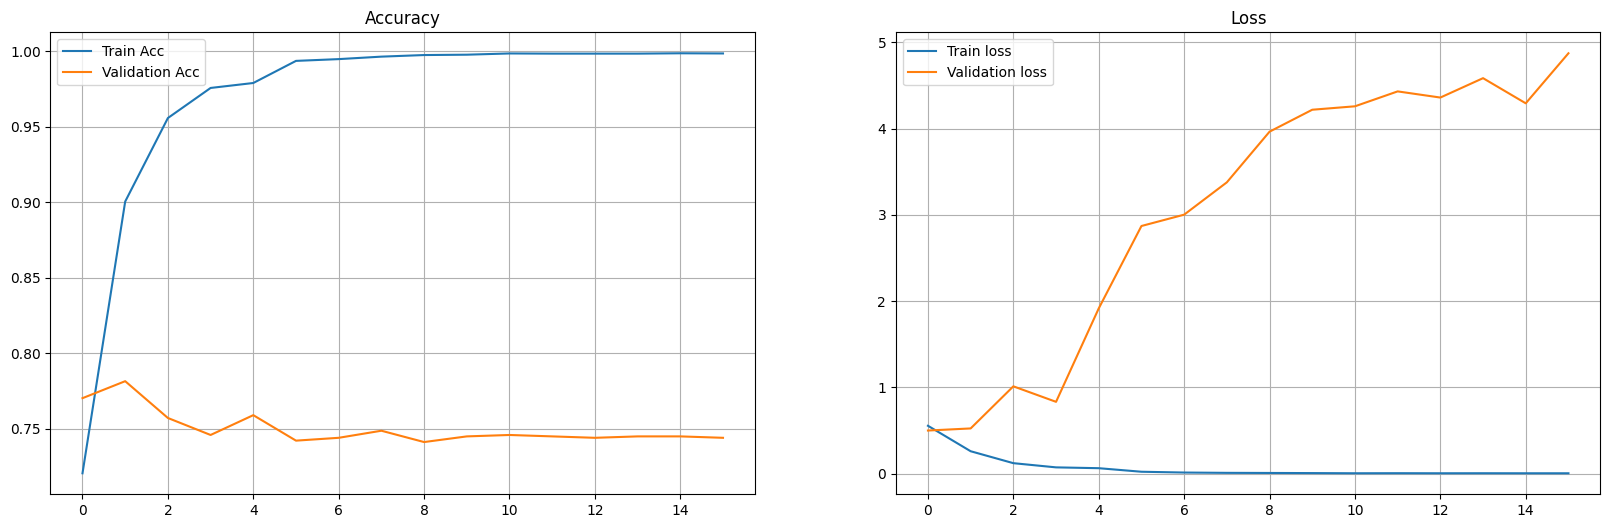

test_loss 4.226578, test_acc 0.747655


In [22]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

In [12]:
from common_utils import HIDDEN_SIZE, EMBEDDING_DIM, LEARNING_RATE

print("The index of <PAD> is: ", word_embeddings.pad_idx)


rnn_attention = RNNWithAttention(
    hidden_dim=HIDDEN_SIZE,
    embedding_dim=EMBEDDING_DIM,
    word_embeddings=word_embeddings.to_tensor,
    dropout_rate=0.3,
    pad_idx=word_embeddings.pad_idx,
    num_layers=1,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
es_patience = 15

model = rnn_attention
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model = model.to(device)
loss_fn = loss_fn.to(device)

train_loss_, train_acc_, val_loss_, val_acc_ = train_model(train_loader, val_loader, model, loss_fn, optimizer, scheduler, epochs, es_patience)

The index of <PAD> is:  16163


  1%|          | 1/100 [00:03<05:08,  3.11s/it]

epoch 1, train_loss 0.596310 train_acc 0.669637, val_loss 0.508746, val_acc 0.749531


 11%|█         | 11/100 [00:30<04:12,  2.84s/it]

epoch 11, train_loss 0.104918 train_acc 0.961782, val_loss 0.770674, val_acc 0.757974


 15%|█▌        | 15/100 [00:45<04:17,  3.03s/it]

early stopping after 16 epochs
best val loss: 0.508746010336009
best accuracy on val set: 0.7636022514071295


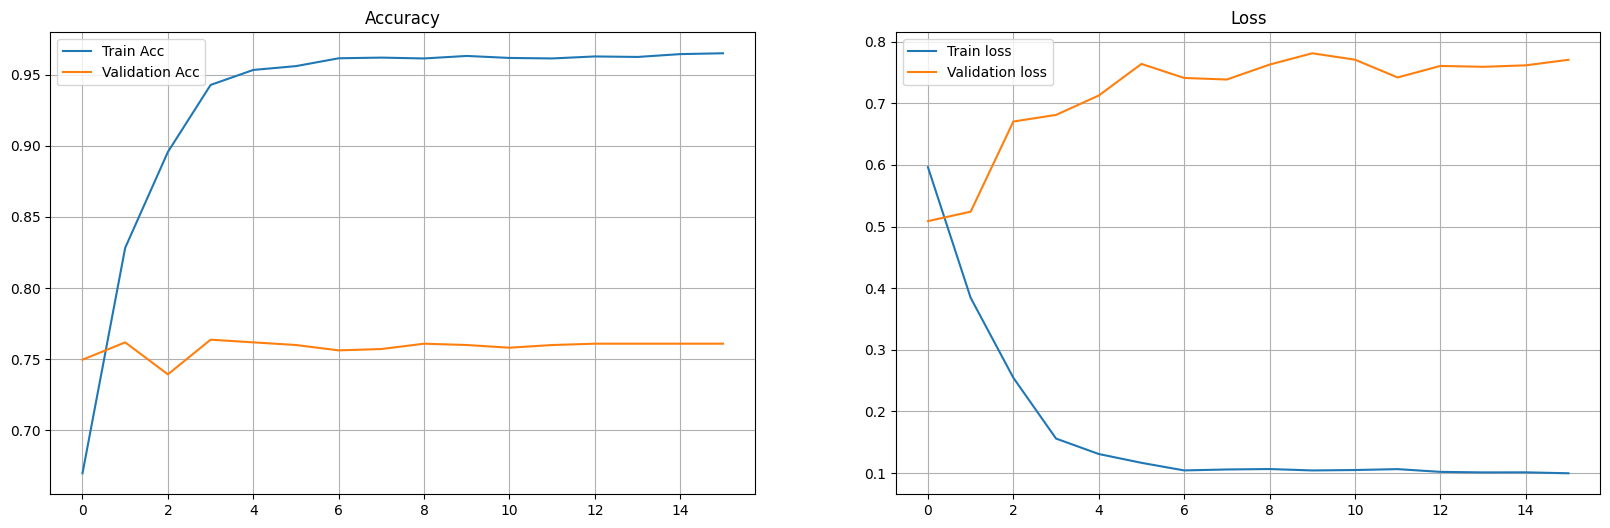

test_loss 0.665855, test_acc 0.778612


In [13]:
plot_loss_accuracy(train_loss_, train_acc_, val_loss_, val_acc_)

test_loss, test_acc = test_loop(test_loader, model, loss_fn, optimizer)
print(f"test_loss {test_loss:>7f}, test_acc {test_acc:>4f}")

Below is the FastText model that can also be used as the embedding instead of the
GloVe embeddings.

In [28]:
import gensim
from gensim.models import FastText
from common_utils import EMBEDDING_DIM
# Create a FastText model with the same dimensions as the Word2Vec model
fasttext_model = FastText(
    vector_size=EMBEDDING_DIM,
    window=5, # context window size 
    min_count=1, # threshold for word frequency
    workers=4
)

# add padding and unknown token
corpus = [["<PAD>", "<UNK>"]] + corpus
print("The corpus has {} documents.".format(len(corpus)))

fasttext_model.build_vocab(corpus_iterable=corpus)
# fasttext_model.build_vocab(corpus_iterable=corpus, update=True)

print("Length of vocabulary:", len(fasttext_model.wv.key_to_index))


fasttext_model.train(
    corpus_iterable=corpus, epochs=fasttext_model.epochs,
    total_examples=fasttext_model.corpus_count, total_words=fasttext_model.corpus_total_words,
)

manual_embedding = EmbeddingMatrix()
idx2word = {str(idx):word for idx, word in enumerate(fasttext_model.wv.index_to_key)}
manual_embedding.load_manual(fasttext_model.wv.key_to_index, idx2word, fasttext_model.wv.vectors)
word_embeddings = manual_embedding

The corpus has 4886 documents.
Length of vocabulary: 12341
